In [53]:
# Import all required libraries for executing code
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn import preprocessing
from scipy.stats import anderson

In [54]:
# Read given data from CSV File
bike_usage = pd.read_csv('day.csv')

In [55]:
# View Data format of read content
bike_usage.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [56]:
# Checking size of data provided
bike_usage.shape

(730, 16)

In [57]:
# Checking for null values to be handled
bike_usage.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [58]:
# There are no null entries in the data set and hence no subsequent action required
# Validate object types for all columns
bike_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


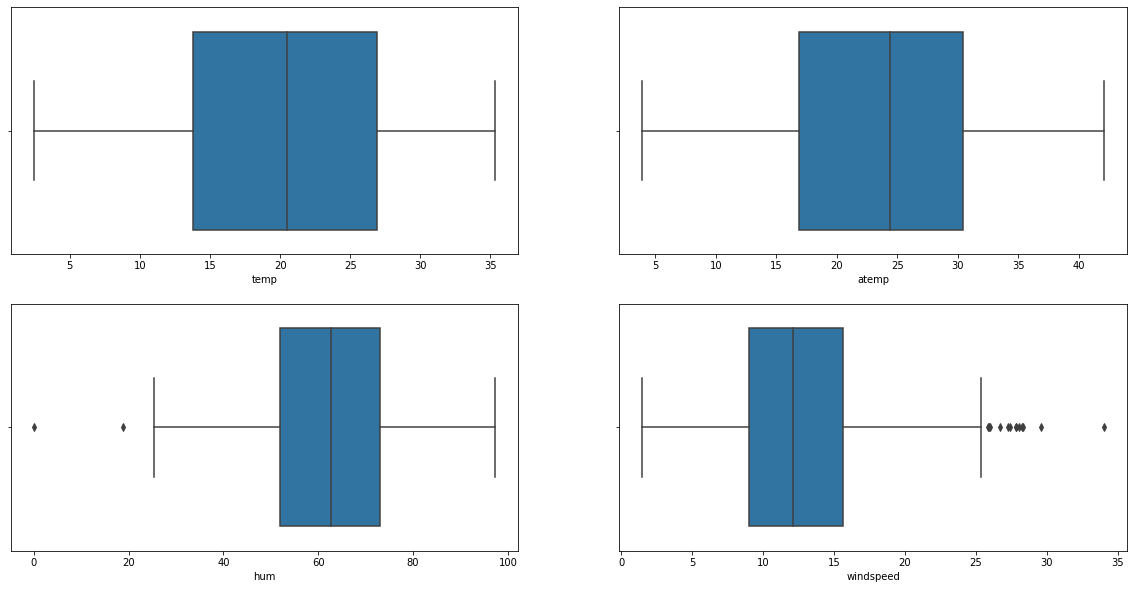

In [59]:
# Checking for outliers (temp	atemp	hum	windspeed)
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.boxplot(data=bike_usage,x='temp')
plt.subplot(2,2,2)
sns.boxplot(data=bike_usage,x='atemp')
plt.subplot(2,2,3)
sns.boxplot(data=bike_usage,x='hum')
plt.subplot(2,2,4)
sns.boxplot(data=bike_usage,x='windspeed')

In [60]:
bike_usage.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [61]:
# Dropping outliers in humidity & windspeed entries
#Calculating upper limit for windspeed
wind_limit = bike_usage.quantile(0.75).windspeed + (1.5 * (bike_usage.quantile(0.75).windspeed - bike_usage.quantile(0.25).windspeed))
#Calculating lower limit for humidity
hum_limit = bike_usage.quantile(0.25).hum - (1.5 * (bike_usage.quantile(0.75).hum - bike_usage.quantile(0.25).hum))
#Checking number of such outlier entries
bike_usage[(bike_usage.hum<hum_limit) | (bike_usage.windspeed>wind_limit)].shape

(14, 16)

In [62]:
# Removing the outlier entries as the count is less than 10% of the total data
bike_usage = bike_usage[~((bike_usage.hum<hum_limit) | (bike_usage.windspeed>wind_limit))]
bike_usage.shape

(716, 16)

In [63]:
# Weekday is numbered from 0 till 6
# We will find the mapping between Sunday and corresponding number by looking for the number marked as non-workign day
bike_usage[bike_usage.workingday ==0].weekday

0      6
1      0
7      6
8      0
14     6
      ..
714    0
721    0
723    2
727    6
728    0
Name: weekday, Length: 226, dtype: int64

Understanding:
We now know that Sunday is represented by numerical 6 in weekday column
All columns are either integers or decimal values except dteday which is a date


Columns to be dropped:
As cnt is our target variable which is total count of rented bikes, we can analyze the dependency of year, month or weekday which are already seperate columns and hence we can drop the dteday column 
Instant column is just like index and hence dropping this colum as well.
We can also drop the column working day because holidays are already represnted in holiday column and Sundays are represented in the weekday column. However, in order to see the possibility of greater dependeny on any kind of holiday, we will leave it for now and remove it from model if it does not play any role.

Derived Columns:
The columns casual & registered are just the count columns split between total users or cnt column. Therefore, they cannot be used as predictors. Therfore, we will derive another column which indicates ratio of registered users to casual users. This can later be used as a predictor, which will indicate the company to get as many people registered as possible.

In [64]:
bike_usage.drop('dteday',axis=1,inplace=True)
bike_usage.drop('instant',axis=1,inplace=True)

In [65]:
# Replacing numerical values in categorical variable columns
bike_usage.season = bike_usage.season.map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})
#bike_usage.yr = bike_usage.yr.map({0: "2018", 1:"2019"})
bike_usage.mnth = bike_usage.mnth.map({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",\
                       7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})
bike_usage.holiday = bike_usage.holiday.map({1:"Festival",0:"Work"})
bike_usage.weekday = bike_usage.weekday.map({0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
bike_usage.workingday = bike_usage.workingday.map({1:"Break",0:"Work"})
bike_usage.weathersit = bike_usage.weathersit.map({1:"VeryClear",2:"MildClear",3:"MildRain",4:"HeavyRain"})

In [66]:
# Renaming yr column
bike_usage.rename(columns = {'yr':'Awareness'},inplace = True)

# Creating a derived column for type of users
bike_usage['ratio_register'] = round(bike_usage['registered'] / bike_usage['casual'],2)

# Dropping the registered & casual columns
bike_usage.drop(['registered','casual'],axis=1,inplace=True)

In [67]:
# Viewing updated data content
bike_usage.head()

,season,Awareness,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,ratio_register
0,spring,0,January,Work,Sunday,Work,MildClear,14.110847,18.18125,80.5833,10.749882,985,1.98
1,spring,0,January,Work,Monday,Work,MildClear,14.902598,17.68695,69.6087,16.652113,801,5.11
2,spring,0,January,Work,Tuesday,Break,VeryClear,8.050924,9.47025,43.7273,16.636703,1349,10.24
3,spring,0,January,Work,Wednesday,Break,VeryClear,8.200000,10.60610,59.0435,10.739832,1562,13.46
4,spring,0,January,Work,Thursday,Break,VeryClear,9.305237,11.46350,43.6957,12.522300,1600,18.51


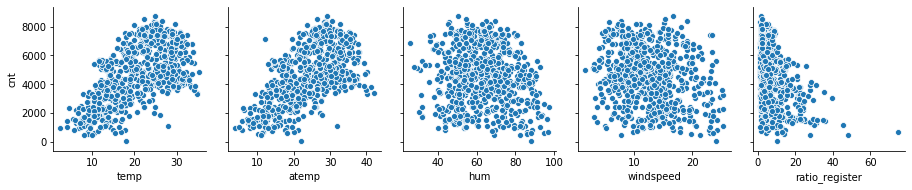

In [68]:
# Visuavilizing numeric variables against target variable
sns.pairplot(bike_usage,y_vars=['cnt'],x_vars=['temp','atemp','hum','windspeed','ratio_register'])

In [69]:
# Clearly temperature seems to have a better linear relation with cnt when compared to other parameters.

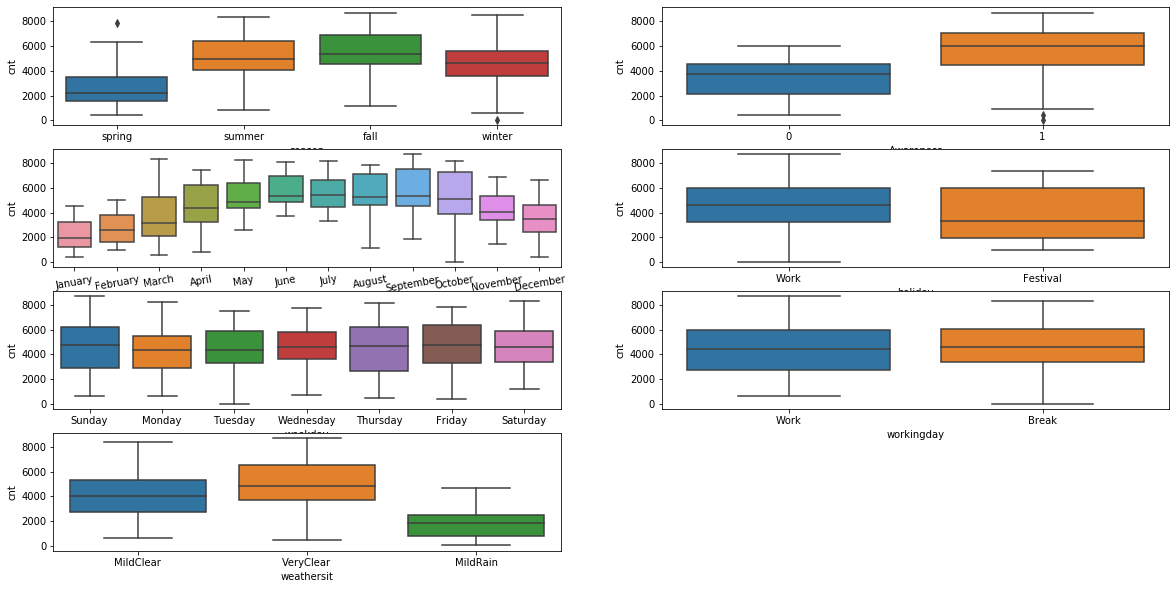

In [70]:
# Visuavilizing categorical variables against target variable
plt.figure(figsize=(20,10))
plt.subplot(4,2,1)
sns.boxplot(data=bike_usage,x='season',y='cnt')
plt.subplot(4,2,2)
sns.boxplot(data=bike_usage,x='Awareness',y='cnt')
plt.subplot(4,2,3)
plt.xticks(rotation=10)
sns.boxplot(data=bike_usage,x='mnth',y='cnt')
plt.subplot(4,2,4)
sns.boxplot(data=bike_usage,x='holiday',y='cnt')
plt.subplot(4,2,5)
sns.boxplot(data=bike_usage,x='weekday',y='cnt')
plt.subplot(4,2,6)
sns.boxplot(data=bike_usage,x='workingday',y='cnt')
plt.subplot(4,2,7)
sns.boxplot(data=bike_usage,x='weathersit',y='cnt')
plt.show()

#Understandings from above boxplots:

1) As we already know, awareness has caused increase in usage.
2) Spring, winter, summer & fall seem to  have an increasing usage in the same sequence.
3) May till Oct seem to have higher usage, which is inline with the behavior observed against seasons. So, we already have an intuation that both might be correlated.
4) Usage seem to be directly linked to weather clarity.
5) All other parameters do not seem to show effect and hence we can follow the same sequence while bulding a model in terms of selecting the probable predictors first

In [71]:
# Creating dummy variables as a preparation for Model setup
# Though we could live with using only n-1 variations against each feature, we will stick to not dropping the first value in order to analyze the possible dependency
bike_dummy = pd.get_dummies(data = bike_usage, columns = ['season','mnth','holiday','weekday','workingday','weathersit'])

In [72]:
# Checking to see the total set of columns after the dummy variable addition
bike_dummy.columns

Index(['Awareness', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'ratio_register', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'mnth_April', 'mnth_August', 'mnth_December',
       'mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March',
       'mnth_May', 'mnth_November', 'mnth_October', 'mnth_September',
       'holiday_Festival', 'holiday_Work', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break',
       'workingday_Work', 'weathersit_MildClear', 'weathersit_MildRain',
       'weathersit_VeryClear'],
      dtype='object')

In [497]:
# Model 2
# Building a model by manually adding variables

In [91]:
# Creating a duplicate dataframe not to disturb the original for future use
bike_m2 = bike_dummy

In [92]:
# Spliting Data again to work on a different combination of data for training & testing
np.random.seed(0)
m2_train,m2_test = train_test_split(bike_m2,train_size=0.7,test_size=0.3,random_state=100)

In [93]:
# Setting up a scalar variable for use. We use a different scalar to see if the behavior differs
scaler = preprocessing.StandardScaler()
# All numerical columns would be scaled to secure best inference capability
m2_train[num_cols] = scaler.fit_transform(m2_train[num_cols])
m2_train.head()

,Awareness,temp,atemp,hum,windspeed,cnt,ratio_register,season_fall,season_spring,season_summer,...,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_Break,workingday_Work,weathersit_MildClear,weathersit_MildRain,weathersit_VeryClear
728,1,-1.287368,-1.467174,-1.075851,2.231625,-1.395736,-0.527267,0,1,0,...,0,0,0,0,0,0,1,0,0,1
541,1,0.754790,0.759566,-1.869980,2.189288,1.478062,-0.248691,1,0,0,...,0,0,0,0,1,1,0,0,0,1
116,0,0.695796,0.639568,1.465968,1.707121,-0.339058,-0.224772,0,0,1,...,0,0,1,0,0,1,0,1,0,0
718,1,-0.883473,-0.832180,0.256726,-0.738090,-0.208755,0.629247,0,0,0,...,0,0,0,0,0,1,0,1,0,0
496,1,0.391743,0.453549,-1.096903,-0.865019,1.471445,-0.822727,0,0,1,...,0,1,0,0,0,0,1,0,0,1


In [94]:
# Creating x & y sets
copy_m2_train = m2_train.copy()
y_train = copy_m2_train.pop('cnt')
x_train = copy_m2_train

In [95]:
# We will start building the model with numerical factors followed by categorical.
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp']])

# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()

# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     379.9
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.46e-63
Time:                        12:32:07   Log-Likelihood:                -569.08
No. Observations:                 501   AIC:                             1142.
Df Residuals:                     499   BIC:                             1151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.294e-16      0.034    6.8e-15      1.0

In [96]:
# Considering we have many other variables. we will try adding other variables and retain them only if they show significant increase in r square value and ofcourse limited impact to adjusted R square value
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_fall']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     192.8
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           9.87e-63
Time:                        12:32:07   Log-Likelihood:                -567.25
No. Observations:                 501   AIC:                             1141.
Df Residuals:                     498   BIC:                             1153.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0525      0.043      1.207      

In [97]:
# There is no much improvement in R square and the features turn out to be insignificant.
# This means they are collinear and hence ignoring and moving with another variable
x_train_manual = sm.add_constant(x_train[['atemp','season_spring']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     221.2
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.83e-69
Time:                        12:32:07   Log-Likelihood:                -551.66
No. Observations:                 501   AIC:                             1109.
Df Residuals:                     498   BIC:                             1122.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1412      0.040      3.508

In [98]:
# atemp seems marginally better and hence will build model on same. The nest series of steps will repeat the same activity of adding/removign variables to find the best combination
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_summer']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     147.9
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.71e-68
Time:                        12:32:07   Log-Likelihood:                -551.07
No. Observations:                 501   AIC:                             1110.
Df Residuals:                     497   BIC:                             1127.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1704      0.048      3.519

In [99]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     151.1
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.42e-69
Time:                        12:32:07   Log-Likelihood:                -548.55
No. Observations:                 501   AIC:                             1105.
Df Residuals:                     497   BIC:                             1122.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0406      0.057      0.714

In [100]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     129.2
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.71e-75
Time:                        12:32:07   Log-Likelihood:                -532.10
No. Observations:                 501   AIC:                             1074.
Df Residuals:                     496   BIC:                             1095.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1880 

In [101]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     116.2
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.98e-81
Time:                        12:32:07   Log-Likelihood:                -516.36
No. Observations:                 501   AIC:                             1045.
Df Residuals:                     495   BIC:                             1070.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1076 

In [102]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','weathersit_MildClear']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     116.2
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.98e-81
Time:                        12:32:07   Log-Likelihood:                -516.36
No. Observations:                 501   AIC:                             1045.
Df Residuals:                     495   BIC:                             1070.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2942 

In [103]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_April']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     96.66
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           4.51e-80
Time:                        12:32:07   Log-Likelihood:                -516.36
No. Observations:                 501   AIC:                             1047.
Df Residuals:                     494   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1103 

In [104]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_August']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     96.66
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           4.52e-80
Time:                        12:32:07   Log-Likelihood:                -516.36
No. Observations:                 501   AIC:                             1047.
Df Residuals:                     494   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1070 

In [105]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_December']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     96.80
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.71e-80
Time:                        12:32:07   Log-Likelihood:                -516.16
No. Observations:                 501   AIC:                             1046.
Df Residuals:                     494   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1029 

In [106]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_February']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     96.68
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           4.38e-80
Time:                        12:32:08   Log-Likelihood:                -516.33
No. Observations:                 501   AIC:                             1047.
Df Residuals:                     494   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1070 

In [107]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_January']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     96.90
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.24e-80
Time:                        12:32:08   Log-Likelihood:                -516.02
No. Observations:                 501   AIC:                             1046.
Df Residuals:                     494   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1023 

In [108]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     98.61
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.16e-81
Time:                        12:32:08   Log-Likelihood:                -513.64
No. Observations:                 501   AIC:                             1041.
Df Residuals:                     494   BIC:                             1071.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0930 

In [109]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July','mnth_June']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     84.54
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.45e-80
Time:                        12:32:08   Log-Likelihood:                -513.34
No. Observations:                 501   AIC:                             1043.
Df Residuals:                     493   BIC:                             1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0823 

In [110]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July','mnth_March']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     84.94
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.30e-80
Time:                        12:32:08   Log-Likelihood:                -512.70
No. Observations:                 501   AIC:                             1041.
Df Residuals:                     493   BIC:                             1075.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1109 

In [111]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July','mnth_May']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     84.37
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.18e-80
Time:                        12:32:08   Log-Likelihood:                -513.61
No. Observations:                 501   AIC:                             1043.
Df Residuals:                     493   BIC:                             1077.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0870 

In [112]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July','mnth_November']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     85.95
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.66e-81
Time:                        12:32:08   Log-Likelihood:                -511.07
No. Observations:                 501   AIC:                             1038.
Df Residuals:                     493   BIC:                             1072.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0924 

In [113]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July','mnth_November','mnth_October']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     75.09
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.38e-80
Time:                        12:32:08   Log-Likelihood:                -510.99
No. Observations:                 501   AIC:                             1040.
Df Residuals:                     492   BIC:                             1078.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0945 

In [114]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter','weathersit_VeryClear','weathersit_MildRain','mnth_July','mnth_November','mnth_September']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     76.58
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.70e-81
Time:                        12:32:08   Log-Likelihood:                -508.28
No. Observations:                 501   AIC:                             1035.
Df Residuals:                     492   BIC:                             1073.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1228 

In [115]:
# until now, Winter & September do not seem to bring a huge impact, we will drop them later in case of overfitting
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_VeryClear','weathersit_MildRain','mnth_November','mnth_September','workingday_Break']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     76.27
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.98e-81
Time:                        12:32:08   Log-Likelihood:                -508.86
No. Observations:                 501   AIC:                             1036.
Df Residuals:                     492   BIC:                             1074.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2000 

In [116]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_VeryClear','weathersit_MildRain','mnth_November','mnth_September','workingday_Work']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     76.27
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.98e-81
Time:                        12:32:08   Log-Likelihood:                -508.86
No. Observations:                 501   AIC:                             1036.
Df Residuals:                     492   BIC:                             1074.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1141 

In [117]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_VeryClear','weathersit_MildRain','mnth_November','mnth_September','holiday_Festival']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     77.59
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.92e-82
Time:                        12:32:09   Log-Likelihood:                -506.47
No. Observations:                 501   AIC:                             1031.
Df Residuals:                     492   BIC:                             1069.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1330 

In [118]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_VeryClear','weathersit_MildRain','mnth_September','holiday_Festival','holiday_Work']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     87.80
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.50e-82
Time:                        12:32:09   Log-Likelihood:                -508.12
No. Observations:                 501   AIC:                             1032.
Df Residuals:                     493   BIC:                             1066.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2491 

In [119]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_VeryClear','weathersit_MildRain','mnth_September','holiday_Festival','hum']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     83.79
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           6.98e-87
Time:                        12:32:09   Log-Likelihood:                -495.53
No. Observations:                 501   AIC:                             1009.
Df Residuals:                     492   BIC:                             1047.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0424 

In [120]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     95.43
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.49e-87
Time:                        12:32:09   Log-Likelihood:                -496.32
No. Observations:                 501   AIC:                             1009.
Df Residuals:                     493   BIC:                             1042.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0104    

In [121]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     89.05
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.21e-90
Time:                        12:32:09   Log-Likelihood:                -486.63
No. Observations:                 501   AIC:                             991.3
Df Residuals:                     492   BIC:                             1029.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0280    

In [122]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','ratio_register']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     79.01
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.13e-89
Time:                        12:32:09   Log-Likelihood:                -486.59
No. Observations:                 501   AIC:                             993.2
Df Residuals:                     491   BIC:                             1035.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0264    

In [123]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     274.8
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          2.30e-185
Time:                        12:32:09   Log-Likelihood:                -260.55
No. Observations:                 501   AIC:                             541.1
Df Residuals:                     491   BIC:                             583.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4488    

In [124]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Friday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     247.1
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          2.95e-184
Time:                        12:32:09   Log-Likelihood:                -260.25
No. Observations:                 501   AIC:                             542.5
Df Residuals:                     490   BIC:                             588.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4437    

In [125]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     252.3
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          4.32e-186
Time:                        12:32:09   Log-Likelihood:                -255.92
No. Observations:                 501   AIC:                             533.8
Df Residuals:                     490   BIC:                             580.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4238    

In [126]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday','weekday_Saturday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     229.6
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          3.74e-185
Time:                        12:32:09   Log-Likelihood:                -255.27
No. Observations:                 501   AIC:                             534.5
Df Residuals:                     489   BIC:                             585.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4361    

In [127]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday','weekday_Sunday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     231.9
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          4.93e-186
Time:                        12:32:09   Log-Likelihood:                -253.19
No. Observations:                 501   AIC:                             530.4
Df Residuals:                     489   BIC:                             581.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4433    

In [128]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday','weekday_Sunday','weekday_Thursday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     212.7
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          4.37e-185
Time:                        12:32:09   Log-Likelihood:                -252.60
No. Observations:                 501   AIC:                             531.2
Df Residuals:                     488   BIC:                             586.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4546    

In [129]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday','weekday_Sunday','weekday_Tuesday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     213.5
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          2.10e-185
Time:                        12:32:09   Log-Likelihood:                -251.85
No. Observations:                 501   AIC:                             529.7
Df Residuals:                     488   BIC:                             584.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4274    

In [130]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday','weekday_Sunday','weekday_Wednesday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     212.2
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          7.46e-185
Time:                        12:32:09   Log-Likelihood:                -253.16
No. Observations:                 501   AIC:                             532.3
Df Residuals:                     488   BIC:                             587.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4407    

In [131]:
# Final Model based on feature selction would be the below
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Festival','hum','windspeed','Awareness','weekday_Monday','weekday_Sunday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     231.9
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          4.93e-186
Time:                        12:32:09   Log-Likelihood:                -253.19
No. Observations:                 501   AIC:                             530.4
Df Residuals:                     489   BIC:                             581.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4433    

In [132]:
# Now since all columns seem to be significant, we will cross check with VIF
x_train_vif = x_train_manual.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = x_train_vif.columns
vif['VIF'] = [variance_inflation_factor(x_train_vif.values,i) for i in range(x_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
1,season_spring,2.13
0,atemp,2.03
8,Awareness,1.69
2,season_winter,1.51
6,hum,1.28
3,weathersit_MildRain,1.19
10,weekday_Sunday,1.16
4,mnth_September,1.15
7,windspeed,1.15
9,weekday_Monday,1.14


In [133]:
# Trying to remove variables with VIF greater than 2.5

In [134]:
# Residual analysis
y_train_pred = lr_mod2.predict(x_train_manual)

Text(0.5, 0, 'Errors')

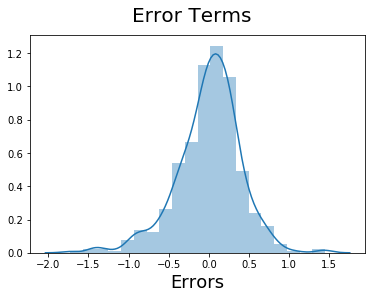

In [135]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [136]:
#Making Predictions on Final Model
# All numerical columns would be scaled to secure best inference capability in the test set

m2_test[num_cols] = scaler.transform(m2_test[num_cols])
m2_test.head()

,Awareness,temp,atemp,hum,windspeed,cnt,ratio_register,season_fall,season_spring,season_summer,...,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_Break,workingday_Work,weathersit_MildClear,weathersit_MildRain,weathersit_VeryClear
583,1,1.326594,1.390879,0.515417,-0.949706,1.392041,-0.420339,1,0,0,...,0,0,0,0,1,1,0,1,0,0
493,1,0.450737,0.503898,0.807202,0.403985,0.091044,-0.150204,0,0,1,...,0,0,1,0,0,1,0,1,0,0
294,0,-0.379740,-0.278415,-0.023024,-1.279494,-0.117135,-0.817099,0,0,0,...,0,1,0,0,0,0,1,0,0,1
157,0,1.172299,1.135261,-0.248629,0.014845,0.150088,-0.330294,0,0,1,...,0,0,0,0,1,1,0,0,0,1
670,1,-0.747329,-0.704435,-0.796101,1.080980,0.666211,0.110082,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [137]:
m2_test.columns

Index(['Awareness', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'ratio_register', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'mnth_April', 'mnth_August', 'mnth_December',
       'mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March',
       'mnth_May', 'mnth_November', 'mnth_October', 'mnth_September',
       'holiday_Festival', 'holiday_Work', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break',
       'workingday_Work', 'weathersit_MildClear', 'weathersit_MildRain',
       'weathersit_VeryClear'],
      dtype='object')

In [138]:
# Creating a copy of test set data
copy_m2_test = m2_test.copy()
# Validating the result from the Model2
y_test = copy_m2_test.pop('cnt')
x_test = copy_m2_test

# Adding constant variable to test dataframe
x_test_m2 = sm.add_constant(x_test)

# Creating x_test_m2 dataframe by dropping variables not in model 2
x_test_m2.drop(['temp', 'ratio_register', 'season_fall', 'season_summer','mnth_April', 'mnth_August', 'mnth_December','mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March','mnth_May', 'mnth_November', 'mnth_October','holiday_Work', 'weekday_Friday','weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break','workingday_Work', 'weathersit_MildClear','weathersit_VeryClear'], axis = 1,inplace=True)

# Making predictions using the 2nd model
y_pred_m2 = lr_mod2.predict(x_test_m2)

#Finding the R square for test set:
r2_score(y_true=y_test,y_pred=y_pred_m2)

-1.6634145560391098

In [132]:
# The R2 square value is negative meaning the the model is incorrect. But since the Rsquare of model is good enough, we now check for overfitting
# We will remove features with higher p value as VIF is less than 5 for now

In [133]:
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','holiday_Work','hum','windspeed','Awareness','weekday_Monday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     252.3
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          4.32e-186
Time:                        11:12:55   Log-Likelihood:                -255.92
No. Observations:                 501   AIC:                             533.8
Df Residuals:                     490   BIC:                             580.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8338    

In [134]:
# Now since all columns seem to be significant, we will cross check with VIF
x_train_vif = x_train_manual.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = x_train_vif.columns
vif['VIF'] = [variance_inflation_factor(x_train_vif.values,i) for i in range(x_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
5,holiday_Work,4.02
1,season_spring,3.15
0,atemp,2.48
2,season_winter,2.11
8,Awareness,2.07
6,hum,1.27
3,weathersit_MildRain,1.21
9,weekday_Monday,1.18
4,mnth_September,1.17
7,windspeed,1.16


Text(0.5, 0, 'Errors')

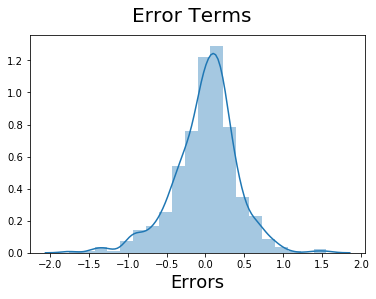

In [135]:
# Residual analysis
y_train_pred = lr_mod2.predict(x_train_manual)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [136]:
# Creating a copy of test set data
copy_m2_test = m2_test.copy()
# Validating the result from the Model2
y_test = copy_m2_test.pop('cnt')
x_test = copy_m2_test

# Adding constant variable to test dataframe
x_test_m2 = sm.add_constant(x_test)

# Creating x_test_m2 dataframe by dropping variables not in model 2
x_test_m2 = x_test_m2.drop(['weekday_Sunday','temp', 'ratio_register', 'season_fall', 'season_summer', 'mnth_April', 'mnth_August', 'mnth_December','mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'holiday_Festival', 'weekday_Friday','weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break','workingday_Work', 'weathersit_MildClear', 'weathersit_VeryClear'], axis = 1)

# Making predictions using the 2nd model
y_pred_m2 = lr_mod2.predict(x_test_m2)

#Finding the R square for test set:
r2_score(y_true=y_test,y_pred=y_pred_m2)

-1.9628012149301877

In [2072]:
# Dropping holiday_Work which has highest VIF
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','hum','windspeed','Awareness','weekday_Monday']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     270.7
Date:                Fri, 27 Nov 2020   Prob (F-statistic):          4.93e-184
Time:                        09:37:10   Log-Likelihood:                -263.68
No. Observations:                 501   AIC:                             547.4
Df Residuals:                     491   BIC:                             589.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4371    

In [2073]:
# Now since all columns seem to be significant, we will cross check with VIF
x_train_vif = x_train_manual.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = x_train_vif.columns
vif['VIF'] = [variance_inflation_factor(x_train_vif.values,i) for i in range(x_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
1,season_spring,2.05
0,atemp,2.02
7,Awareness,1.66
2,season_winter,1.45
5,hum,1.27
3,weathersit_MildRain,1.19
4,mnth_September,1.15
6,windspeed,1.15
8,weekday_Monday,1.12


Text(0.5, 0, 'Errors')

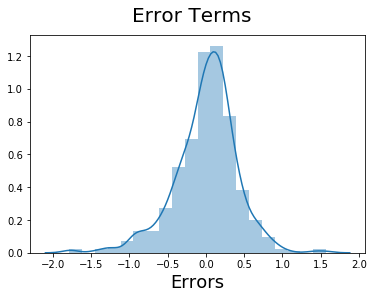

In [2074]:
# Residual analysis
y_train_pred = lr_mod2.predict(x_train_manual)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [2075]:
# Creating a copy of test set data
copy_m2_test = m2_test.copy()
# Validating the result from the Model2
y_test = copy_m2_test.pop('cnt')
x_test = copy_m2_test

# Adding constant variable to test dataframe
x_test_m2 = sm.add_constant(x_test)

# Creating x_test_m2 dataframe by dropping variables not in model 2
x_test_m2 = x_test_m2.drop(['holiday_Work','weekday_Sunday','temp', 'ratio_register', 'season_fall', 'season_summer', 'mnth_April', 'mnth_August', 'mnth_December','mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'holiday_Festival', 'weekday_Friday','weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break','workingday_Work', 'weathersit_MildClear', 'weathersit_VeryClear'], axis = 1)

# Making predictions using the 2nd model
y_pred_m2 = lr_mod2.predict(x_test_m2)

#Finding the R square for test set:
r2_score(y_true=y_test,y_pred=y_pred_m2)

-1.6258581485602939

In [2076]:
# Dropping weekday_Monday which has highest VIF
# Add a constant
x_train_manual = sm.add_constant(x_train[['atemp','season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','hum','windspeed','Awareness']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     299.8
Date:                Fri, 27 Nov 2020   Prob (F-statistic):          9.90e-184
Time:                        09:38:38   Log-Likelihood:                -267.35
No. Observations:                 501   AIC:                             552.7
Df Residuals:                     492   BIC:                             590.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4589    

In [2077]:
# Now since all columns seem to be significant, we will cross check with VIF
x_train_vif = x_train_manual.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = x_train_vif.columns
vif['VIF'] = [variance_inflation_factor(x_train_vif.values,i) for i in range(x_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
0,atemp,1.99
1,season_spring,1.98
7,Awareness,1.65
2,season_winter,1.42
5,hum,1.27
3,weathersit_MildRain,1.19
6,windspeed,1.15
4,mnth_September,1.14


Text(0.5, 0, 'Errors')

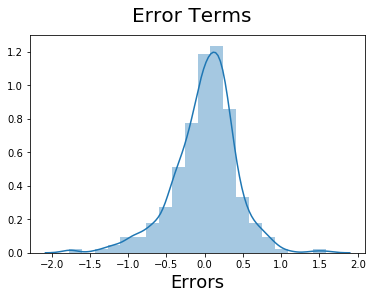

In [2078]:
# Residual analysis
y_train_pred = lr_mod2.predict(x_train_manual)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [2079]:
# Creating a copy of test set data
copy_m2_test = m2_test.copy()
# Validating the result from the Model2
y_test = copy_m2_test.pop('cnt')
x_test = copy_m2_test

# Adding constant variable to test dataframe
x_test_m2 = sm.add_constant(x_test)

# Creating x_test_m2 dataframe by dropping variables not in model 2
x_test_m2 = x_test_m2.drop(['weekday_Monday','holiday_Work','weekday_Sunday','temp', 'ratio_register', 'season_fall', 'season_summer', 'mnth_April', 'mnth_August', 'mnth_December','mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'holiday_Festival', 'weekday_Friday','weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break','workingday_Work', 'weathersit_MildClear', 'weathersit_VeryClear'], axis = 1)

# Making predictions using the 2nd model
y_pred_m2 = lr_mod2.predict(x_test_m2)

#Finding the R square for test set:
r2_score(y_true=y_test,y_pred=y_pred_m2)

-1.5823259966128393

In [2080]:
# Dropping atemp which has highest VIF
# Add a constant
x_train_manual = sm.add_constant(x_train[['season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','hum','windspeed','Awareness']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     202.1
Date:                Fri, 27 Nov 2020   Prob (F-statistic):          1.99e-140
Time:                        09:40:05   Log-Likelihood:                -371.96
No. Observations:                 501   AIC:                             759.9
Df Residuals:                     493   BIC:                             793.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1718    

In [2081]:
# Now since all columns seem to be significant, we will cross check with VIF
x_train_vif = x_train_manual.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = x_train_vif.columns
vif['VIF'] = [variance_inflation_factor(x_train_vif.values,i) for i in range(x_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
6,Awareness,1.38
4,hum,1.25
1,season_winter,1.19
2,weathersit_MildRain,1.18
0,season_spring,1.17
5,windspeed,1.13
3,mnth_September,1.10


Text(0.5, 0, 'Errors')

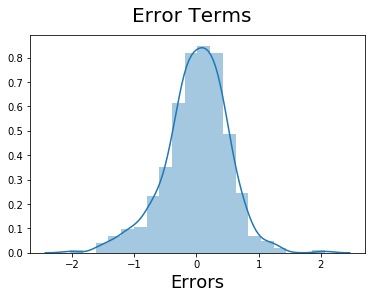

In [2082]:
# Residual analysis
y_train_pred = lr_mod2.predict(x_train_manual)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [2083]:
# Creating a copy of test set data
copy_m2_test = m2_test.copy()
# Validating the result from the Model2
y_test = copy_m2_test.pop('cnt')
x_test = copy_m2_test

# Adding constant variable to test dataframe
x_test_m2 = sm.add_constant(x_test)

# Creating x_test_m2 dataframe by dropping variables not in model 2
x_test_m2 = x_test_m2.drop(['atemp','weekday_Monday','holiday_Work','weekday_Sunday','temp', 'ratio_register', 'season_fall', 'season_summer', 'mnth_April', 'mnth_August', 'mnth_December','mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'holiday_Festival', 'weekday_Friday','weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break','workingday_Work', 'weathersit_MildClear', 'weathersit_VeryClear'], axis = 1)

# Making predictions using the 2nd model
y_pred_m2 = lr_mod2.predict(x_test_m2)

#Finding the R square for test set:
r2_score(y_true=y_test,y_pred=y_pred_m2)

-2.598755478629073

In [2084]:
# Dropping Awareness which has highest VIF
# Add a constant
x_train_manual = sm.add_constant(x_train[['season_spring','season_winter',\
                                          'weathersit_MildRain','mnth_September','hum','windspeed']])
# Create a first fitted model
lr_mod2 = sm.OLS(y_train, x_train_manual).fit()
# Summary
print(lr_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     71.46
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           6.31e-64
Time:                        09:42:01   Log-Likelihood:                -554.36
No. Observations:                 501   AIC:                             1123.
Df Residuals:                     494   BIC:                             1152.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3871    

In [2085]:
# Now since all columns seem to be significant, we will cross check with VIF
x_train_vif = x_train_manual.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = x_train_vif.columns
vif['VIF'] = [variance_inflation_factor(x_train_vif.values,i) for i in range(x_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
4,hum,1.22
2,weathersit_MildRain,1.18
5,windspeed,1.12
1,season_winter,1.06
3,mnth_September,1.04
0,season_spring,1.03


Text(0.5, 0, 'Errors')

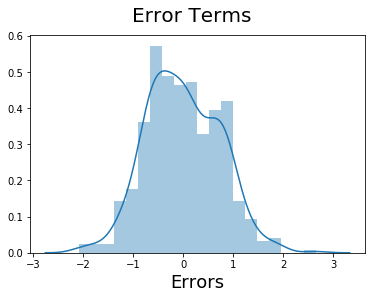

In [2086]:
# Residual analysis
y_train_pred = lr_mod2.predict(x_train_manual)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [2087]:
# Creating a copy of test set data
copy_m2_test = m2_test.copy()
# Validating the result from the Model2
y_test = copy_m2_test.pop('cnt')
x_test = copy_m2_test

# Adding constant variable to test dataframe
x_test_m2 = sm.add_constant(x_test)

# Creating x_test_m2 dataframe by dropping variables not in model 2
x_test_m2 = x_test_m2.drop(['Awareness','atemp','weekday_Monday','holiday_Work','weekday_Sunday','temp', 'ratio_register', 'season_fall', 'season_summer', 'mnth_April', 'mnth_August', 'mnth_December','mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'holiday_Festival', 'weekday_Friday','weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'workingday_Break','workingday_Work', 'weathersit_MildClear', 'weathersit_VeryClear'], axis = 1)

# Making predictions using the 2nd model
y_pred_m2 = lr_mod2.predict(x_test_m2)

#Finding the R square for test set:
r2_score(y_true=y_test,y_pred=y_pred_m2)

-1.1454933344995286